In [1]:
import csv
import sys
import pandas as pd
import re

# Data Load

In [2]:
ls16raw = pd.read_csv("./libsort16b.csv", skiprows=[4], 
                 comment="=")

ls8raw = pd.read_csv("./libsort8b.csv", skiprows=[4], 
                 comment="=")

py16raw = pd.read_csv("./faas16b.csv")
py8raw = pd.read_csv("./faas8b.csv")

# Data Cleaning

In [33]:
renames = {
    "gpu_radix_sort_local(unsigned int*, unsigned int*, unsigned int*, unsigned int, unsigned int*, unsigned int, unsigned int)" : ("GpuSort", "core"),
    "[CUDA memcpy HtoD]" : ("Host->Device", "data"),
    "[CUDA memcpy DtoH]" : ("Device->Host", "data"),
    "gpu_glbl_shuffle(unsigned int*, unsigned int*, unsigned int*, unsigned int*, unsigned int, unsigned int, unsigned int)" : ("GpuShuffle", "core"),
    "gpu_prescan(unsigned int*, unsigned int const *, unsigned int*, unsigned int, unsigned int, unsigned int)" : ("GpuSortHelper0", "core"),
    'gpu_groups(unsigned int*, unsigned int*, int, int, unsigned int)' : ("GpuBoundaries", "distrib"),
    "gpu_add_block_sums(unsigned int*, unsigned int const *, unsigned int*, unsigned long)" : ("GpuSortHelper1", "core")
}

def cleanNvprof(orig):
    df = orig.copy()
    
    # subset for only significant api calls
    df = df[ df['Type'] == "GPU activities" ].drop(['Type'], axis=1)
    df = df[ df['Time(%)'] > 0.5 ]
    
    # Human readable names and categories
    for oldName, cleaned in renames.items():
        df.loc[ (df['Name'] == oldName), 'Category' ] = cleaned[1]
        df.loc[ (df['Name'] == oldName), 'Name' ] = cleaned[0]

    # summarize by category
    df = df.groupby(["Category"]).sum()[['Time(%)', 'Time']]

    return df

def cleanCprofile(orig):
    df = orig.copy()
    
    # Extract just the function name from the output
    reFname = re.compile(".*:.*\((.*)\)")
    def filterFName(x):
        m = reFname.match(x)
        if m is not None:
            return m.group(1)
        else:
            return x
        
    df.loc[:,['filename:lineno(function)']] = df.loc[:,['filename:lineno(function)']].applymap(filterFName)
    df.rename(columns={'filename:lineno(function)':"function"}, inplace=True)
    
    # Only want cumtime
    df = df.drop(['ncalls','tottime','percall', 'percall.1'], axis=1)
    
    # Convert to ms
    df['cumtime'] *= 1000
    
    df.rename(columns={'cumtime' : 'time'}, inplace=True)
    df.set_index('function', inplace=True)
    
    leaves = pd.Series(dtype=float)
    
    leaves['libsort'] = df.loc['sortPartial', 'time']
    leaves['writeMeta'] = df.loc['Close', 'time']
    leaves['writeData'] = df.loc['WriteAll', 'time']
    leaves['readData'] = df.loc['ReadPart', 'time']
    leaves['readMeta'] = df.loc['readPartRefs', 'time'] - leaves['readData']
    
    return leaves

def combine(ls, py):
    faas = py.copy()
    faas['libsort-core'] = py['libsort'] - ls.loc['data', 'Time']
    faas['libsort-memcpy'] = py['libsort'] - ls.loc['core', 'Time']
    faas.drop('libsort', inplace=True)

    return faas
    
ls16 = cleanNvprof(ls16raw)
ls8 = cleanNvprof(ls8raw)
py16 = cleanCprofile(py16raw)
py8 = cleanCprofile(py8raw)

faas16 = combine(ls16, py16)
faas8 = combine(ls8, py8)

# Plot Time Breakdowns

## LibSort

Text(0, 0.5, 'Time (ms)')

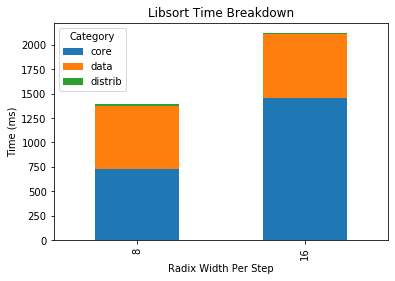

In [34]:
t8 = ls8.T.loc['Time'].rename("8")
t16 = ls16.T.loc['Time'].rename("16")
pltDf = pd.DataFrame([t8, t16])
ax = pltDf.plot.bar(stacked=True)

ax.set_title("Libsort Time Breakdown")
ax.set_xlabel("Radix Width Per Step")
ax.set_ylabel("Time (ms)")

## Full FaaS

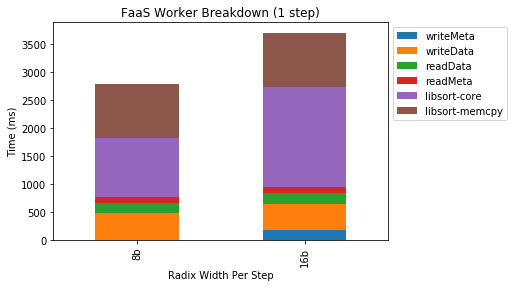

In [35]:
pltDf = pd.DataFrame([faas8, faas16], index=["8b", "16b"])
ax = pltDf.plot.bar(stacked=True)

ax.set_xlabel("Radix Width Per Step")
ax.set_ylabel("Time (ms)")
ax.set_title("FaaS Worker Breakdown (1 step)")
ax.legend(bbox_to_anchor=(1.0, 1.0))